# Kernel Mixture Network class
Notebook to perform interactive tests.

In [1]:
sys.path.append('../')

import numpy as np
import pandas as pd

# neural networks
import keras
import edward as ed
import tensorflow as tf

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# module loading settings
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Size of features in training data: (3750, 1)
Size of output in training data: (3750,)
Size of features in test data: (1250, 1)
Size of output in test data: (1250,)


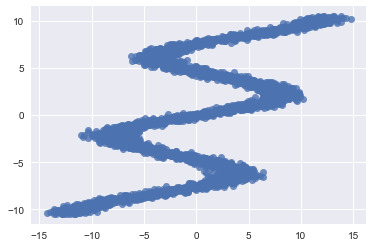

In [2]:
from sklearn.model_selection import train_test_split

def build_toy_dataset(n):
    y_data = np.random.uniform(-10.5, 10.5, n)
    r_data = np.random.normal(size=n)  # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((n, 1))
    return train_test_split(x_data, y_data, random_state=42)

n_observations = 5000  # number of data points
n_features = 1  # number of features

X_train, X_test, y_train, y_test = build_toy_dataset(n_observations)
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

sns.regplot(X_train, y_train, fit_reg=False);

In [3]:
from src.kmn import KernelMixtureNetwork

kmn = KernelMixtureNetwork()
kmn.fit(X_train, y_train, n_epoch=100, eval_set=(X_test, y_test))

fitting model
100/100 [100%] ██████████████████████████████ Elapsed: 2s | Loss: 6816.231
mean log-loss train: 1.818
man log-loss test: 1.831
optimal scales: [ 0.47066727]


In [4]:
kmn.partial_fit(X_train, y_train, n_epoch=200, eval_set=(X_test, y_test))

fitting model
mean log-loss train: 1.807
man log-loss test: 1.823
optimal scales: [ 0.47037506]


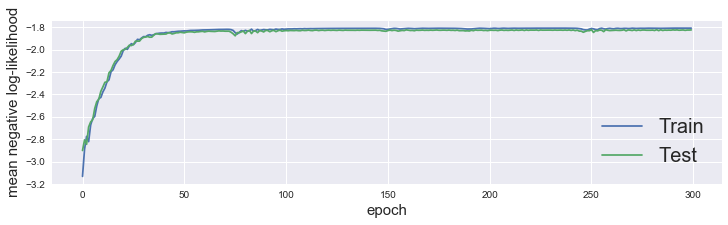

In [5]:
kmn.plot_loss();

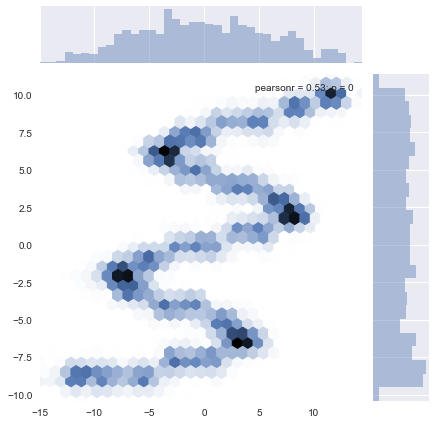

In [6]:
samples = kmn.sample(X_test)
xs = np.tile(X_test.ravel(), kmn.n_samples)
ys = samples.flatten()   
sns.jointplot(xs, ys, kind="hex");

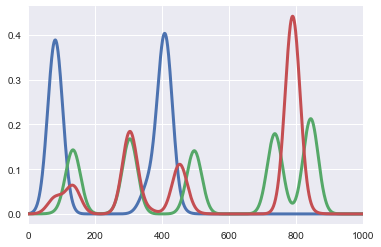

In [7]:
d = kmn.predict_density(X_test[0:3,:].reshape(-1,1), resolution=1000)
df = pd.DataFrame(d).transpose()
df.plot(legend=False, linewidth=3);

In [8]:
np.log(kmn.predict(X_train, y_train)).mean()

-1.8073852

In [9]:
kmn.score(X_train, y_train)

-1.8073852

External estimator.

In [10]:
kmn.sess.close()

In [13]:
from keras.layers import Dense

X_ph = tf.placeholder(tf.float32, [None, n_features])
x = Dense(32, activation='relu')(X_ph)
x = Dense(16, activation='relu')(x)
neural_network = Dense(8, activation='relu')(x)

kmn = KernelMixtureNetwork(estimator=neural_network, X_ph=X_ph)
kmn.fit(X_train, y_train, n_epoch=200)

fitting model
200/200 [100%] ██████████████████████████████ Elapsed: 3s | Loss: 7045.899
mean log-loss train: 1.879
optimal scales: [ 0.51508623]
